# Классификация произведений писателей

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation, Embedding # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from google.colab import drive # Для работы с Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Удаляем директорию с распакованными данными (если есть)
!rm -rf /content/books

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Machine_learning/Datasets/books.zip' -d /content/

In [ ]:
# Функция для загрузки файла
def loadText(fileName):
  f = open(fileName, 'r') # Открываем файл в режиме чтения
  text = f.read()         # Читаем текст
  text = text.replace("\n", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\r", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\t", " ") # Заменяем табуляции на пробелы
  f.close()
  
  return text

labels = ["Достоевский", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Тургенев"] # Наши авторы
labelsNum = len(labels) # Количество авторов

In [ ]:
# Загружаем тексты из обучающей и тренировочной выборок

trainText = [] # Обучающие тексты
testText = []  # Тестовые тексты

fileList = os.listdir('books/') # Получаем список всех файлов
for label in labels:
  for file in fileList:
    if label in file: # Проверяем, содержит ли файл j в названии имя класса i
      if 'Обучающая' in file: # Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(loadText('books/' + file)) #добавляем в обучающую выборку
        print(file, 'добавлен в обучающую выборку')
      if 'Тестовая' in file: # Если в имени найденного класса есть строка "Тестовая"
        testText.append(loadText('books/' + file)) #добавляем в обучающую выборку
        print(file, 'добавлен в тестовую выборку')

(Достоевский) - Тестовая выборка.txt добавлен в тестовую выборку
(Достоевский) - Обучающая выборка.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Тургенев) - Обучающая выборка.txt добавлен в обучающую выборку
(Тургенев) - Тестовая выборка.txt добавлен в тестовую выборку


In [ ]:
print("Количество загруженных тренировочных текстов:", len(trainText))
print("Количество загруженных проверочных текстов:", len(testText))

Количество загруженных тренировочных текстов: 6
Количество загруженных проверочных текстов: 6


Токенизируем тексты

In [ ]:
numWords = 20000 # Количество слов/индексов, которое мы будем учитывать при обучении

# Tokenizer - встроенная в Keras функция для разбиения текста и превращения
# в слов в числовые значения с учётом частотности

# num_words - максимальное количество слов/индексов, учитываемое при составлении словаря
# filters - список ненужных символов, которые будут удалены из текстов
# lower - приведение слов к нижнему регистру
# split - разделитель между словами
# oov_token - на какое слово будем заменять слова, которые выше по частоте, чем numWords
# char_level - разбитие по буквам или по словам

tokenizer = Tokenizer(num_words=numWords,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText) # Cоберем словарь частотности
items = list(tokenizer.word_index.items()) # Получаем индексы слов

In [ ]:
print("Самые часто встречающиеся слова:")
print(items[:10]) # Самые часто встречающиеся слова
print()
print("Самые редко встречающиеся слова:")
print(items[-10:])
print()
print("Размер словаря:", len(items))

Самые часто встречающиеся слова:
[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10)]

Самые редко встречающиеся слова:
[('322322', 146754), ('323323', 146755), ('324324', 146756), ('325325', 146757), ('изменник', 146758), ('326326', 146759), ('матросскую', 146760), ('модную', 146761), ('327327', 146762), ('дерзай', 146763)]

Размер словаря: 146763


In [ ]:
# # Тестирование словаря
# inputWord = input("Введите слово: ")
# print("Индекс слова ",inputWord, ": ", tokenizer.word_index[inputWord])

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [ ]:
# Проверим преобразование
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[3][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[3][:20], '\n')

Фрагмент обучающего текста:
В виде оригинального текста:               ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказал
Он же в виде последовательности индексов:  [119, 3732, 49, 5, 8178, 26, 496, 1, 2, 2135, 7, 1169, 1324, 749, 2786, 8168, 4160, 1, 8, 1] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], " "*(10-len(labels[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(labelsNum): #Проходим по всем классам
  print(labels[i], ' '*(10-len(labels[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Достоевский  2171809 символов,  347667 слов
Стругацкие  2042469 символов,  313012 слов
Булгаков    1765632 символов,  261460 слов
Саймак      1609507 символов,  251502 слов
Фрай        3700010 символов,  568533 слов
Тургенев    3236768 символов,  504484 слов
----
В сумме  14526195  символов,  2246658  слов 


Статистика по тестовым текстам:
Достоевский  223527 символов,  36410 слов
Стругацкие  704846 символов,  108621 слов
Булгаков    875042 символов,  132730 слов
Саймак      318811 символов,  50360 слов
Фрай        1278191 символов,  196731 слов
Тургенев    213142 символов,  33503 слов
----
В сумме  3613559  символов,  558355  слов


Создаем xTrain и yTrain

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [ ]:
# Задаём базовые параметры
xLen = 500 # Размер окна (количество слов в векторе)
step = 60 # Шаг разбиения текста на векторы

In [ ]:
# Формируем обучающую и тестовую выборку
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)

Размерности тренировочного набора
(37398, 500)
(37398, 6)

Размерности тестового набора
(1114, 500)
(1114, 6)


In [ ]:
print(xTrainId[0])

[ 3177  2002     3   557     1 11626     1     1     3  1893   348    10
  3230 11031 18450     1     1     1 18451     2   125  4608     1  1011
  4228   517     1     1 18452  2494     2     1  2191  2368   176    77
     1     2     1     7  1950     2    95     1  7596   856  1894  5610
     3   443  6409     3     1   531     3  3480   714  4931     1     1
  5447   882     7   135     1  5448    19     1    30    20     1     2
 11032     6  8163 18453     3  2120  1510  3881     2  4709    32   882
   562    30  2495   159     6    84    26  3125 11627    26     1   107
     2     1    26    24  4509    14   156   107     1     1    58  1934
 10023     2   119     1  9590     2 18454     4    26    51     1    16
    11  3178 12974    17   135     1    24   351   114    16     1    16
   350   107  2552  3675    71  2318  4046     3   629    26     1  1934
 10023     8  6598  9591   267   479   554    17   224   636   166     1
   506   180  1860   506   125     1   506     4 15

In [ ]:
# Не преобразуем в Bag Of Words

# xTrain  = tokenizer.sequences_to_matrix(xTrainId.tolist())
# xTest  = tokenizer.sequences_to_matrix(xTestId.tolist())

xTrain = xTrainId
xTest  = xTestId

print("Размерность обучайющей выборки")
print(xTrain.shape)
print(yTrain.shape)

print()

print("Размерность тестовой выборки")
print(xTest.shape)
print(yTest.shape)


Размерность обучайющей выборки
(37398, 500)
(37398, 6)

Размерность тестовой выборки
(1114, 500)
(1114, 6)


Нейросеть для классификации текстов на базе Embedding

In [ ]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Embedding(numWords, 10, input_length=xLen))
model.add(SpatialDropout1D(0.20))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 10)           200000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 10)          0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 batch_normalization (BatchN  (None, 5000)             20000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 6)                 30006     
                                                                 
Total params: 250,006
Trainable params: 240,006
Non-trai

In [ ]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/20
468/468 [==============================] - 7s 9ms/step - loss: 0.4623 - accuracy: 0.8396 - val_loss: 2.1949 - val_accuracy: 0.0422
Epoch 2/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0164 - accuracy: 0.9968 - val_loss: 2.4625 - val_accuracy: 0.1656
Epoch 3/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 2.9647 - val_accuracy: 0.1293
Epoch 4/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 3.4809 - val_accuracy: 0.0850
Epoch 5/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 3.9805 - val_accuracy: 0.0774
Epoch 6/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 3.6909 - val_accuracy: 0.1106
Epoch 7/20
468/468 [==============================] - 4s 8ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 3.6228 - val_accuracy: 0.1414
Epoch 

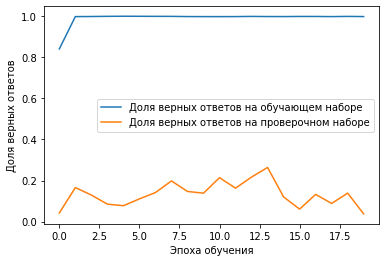

In [ ]:
# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Проверяем работу обученной нейросети

In [ ]:
# Проверяем точность на тестовой выборке

rightAnswer = [0,0,0,0,0,0]
totalAnswer = [0,0,0,0,0,0]

# Получаем результаты распознавания для каждого класса
currPred = model.predict(xTest)
# Определяем номер распознанного класса для каждохо вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждохо вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()


# Считаем сколько ответов всего и сколько из них правильных
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

# Подсчитываем точность классификации
print("Точность распознавания текстов писателей")
for i in range(labelsNum):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], rightAnswer[i], totalAnswer[i], (rightAnswer[i]/totalAnswer[i]*100)))

(1114, 6)
(1114,)
(1114,)

Точность распознавания текстов писателей
Достоевский :  72 из  72 - 100.00%
Стругацкие  : 119 из 217 - 54.84%
Булгаков    : 123 из 265 - 46.42%
Саймак      :  56 из 100 - 56.00%
Фрай        : 359 из 393 - 91.35%
Тургенев    :   9 из  67 - 13.43%
